# Data basic exploration

In [2]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
# Data_looking.ipynb

# Import necessary libraries

# Load the datasets
stores = pd.read_csv('https://raw.githubusercontent.com/PietroWei/Global-Sales-Analysis-and-Forecasting/refs/heads/main/data/stores.csv')
features = pd.read_csv('https://raw.githubusercontent.com/PietroWei/Global-Sales-Analysis-and-Forecasting/refs/heads/main/data/features.csv')
train = pd.read_csv('https://raw.githubusercontent.com/PietroWei/Global-Sales-Analysis-and-Forecasting/refs/heads/main/data/train.csv')



# Merge the datasets on 'Store' and 'Date'
merged_df = pd.merge(train, features, on=['Store', 'Date'])
merged_df = pd.merge(merged_df, stores, on='Store')

# Convert the 'Date' column to the format dd/mm/yyyy
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Check if IsHoliday_x and IsHoliday_y are equal, if not set to NaN
merged_df['IsHoliday'] = merged_df.apply(lambda row: row['IsHoliday_x'] if row['IsHoliday_x'] == row['IsHoliday_y'] else pd.NA, axis=1)

# Remove IsHoliday_x and IsHoliday_y columns
merged_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'], inplace=True)

# Convert 'IsHoliday' from boolean to 0 or 1 (with NaN considered as 0)
merged_df['IsHoliday'] = merged_df['IsHoliday'].fillna(False).astype(int)

# Map 'Type' from 'A', 'B', 'C' to 1, 2, 3 respectively
merged_df['Type'] = merged_df['Type'].map({'A': 1, 'B': 2, 'C': 3})

# Display the first few rows of the merged dataframe to confirm changes
merged_df.head()


,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,0
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,0
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,0
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,0
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,0


## Dealing with NaN values

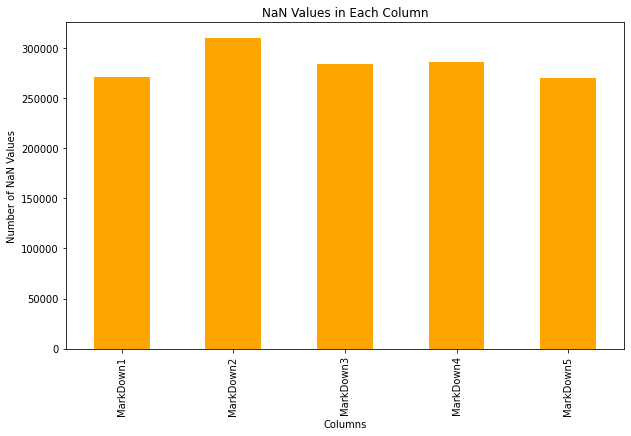

In [4]:
# Plotting the NaN values
plt.figure(figsize=(10, 6))
nan_values = merged_df.isna().sum()
nan_values = nan_values[nan_values > 0]
nan_values.plot(kind='bar', color='orange')
plt.title('NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

# Replace the NaN values in markdown with 0
merged_df = merged_df.fillna(0)

## Basic exploration

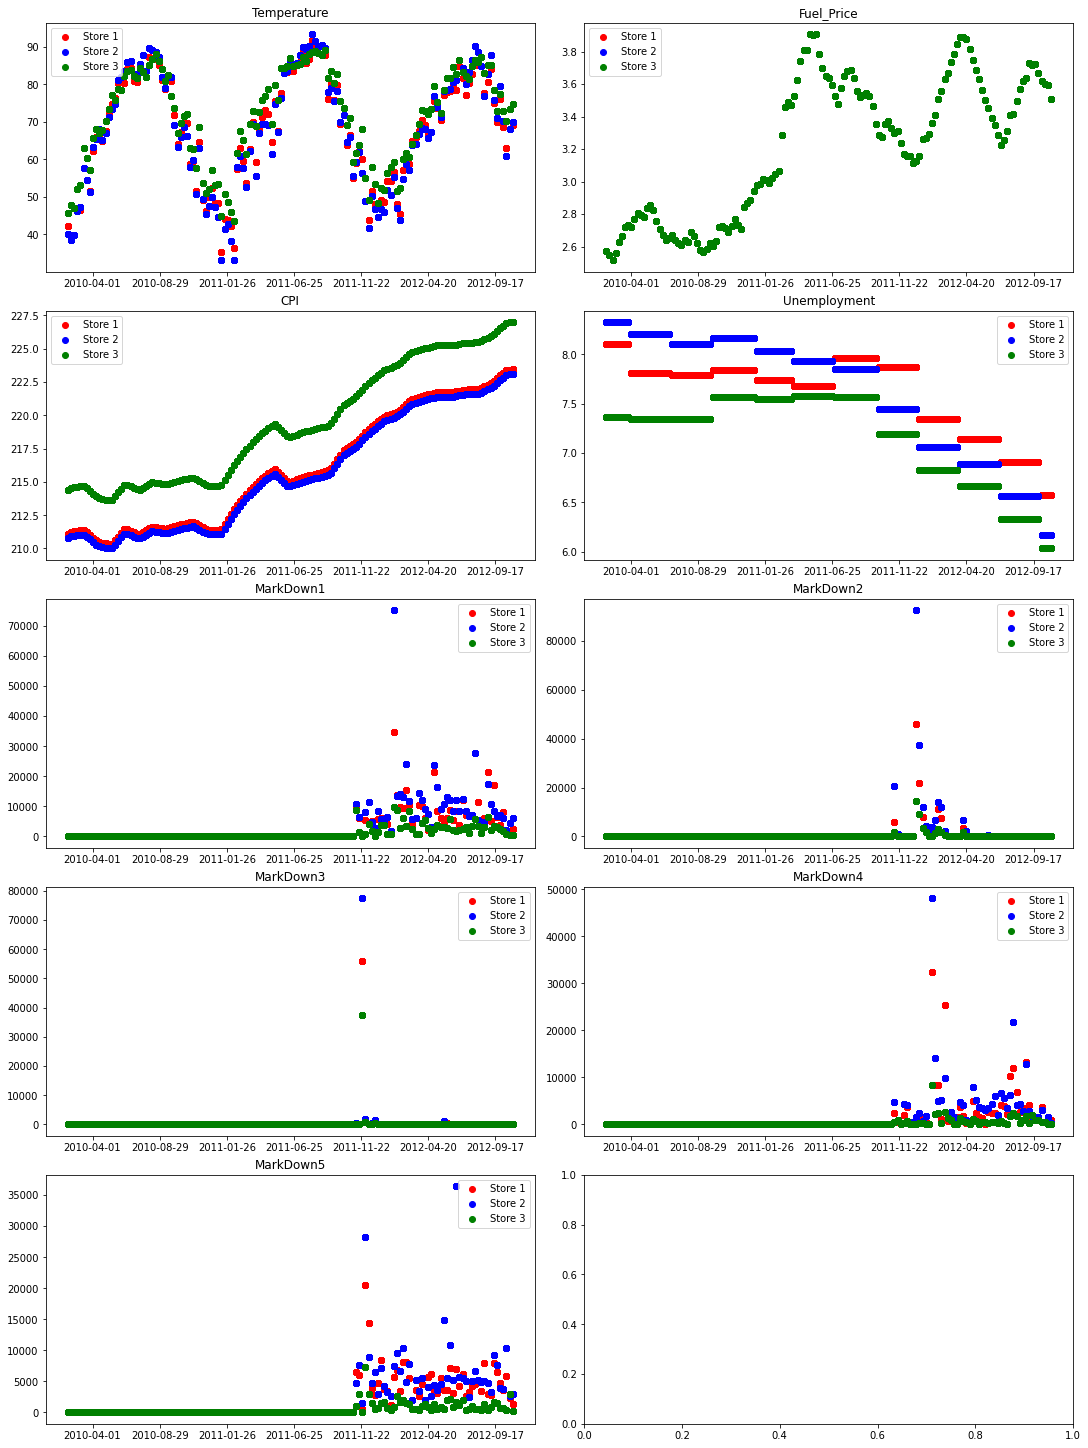

In [5]:
# Basic plots overview
selected_stores = merged_df['Store'].unique()[:3]

# Plots for the different features in the df:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), constrained_layout=True)
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
colors = {1: 'red', 2: 'blue', 3: 'green'}
for ax, feature in zip(axes.flatten(), features):
    for store in selected_stores:
        store_data = merged_df[merged_df['Store'] == store]
        ax.scatter(store_data['Date'], store_data[feature], label=f'Store {store}', color=colors[store])
    ax.set_title(feature)
    # Set equidistant x-axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
    ax.legend()
plt.show()

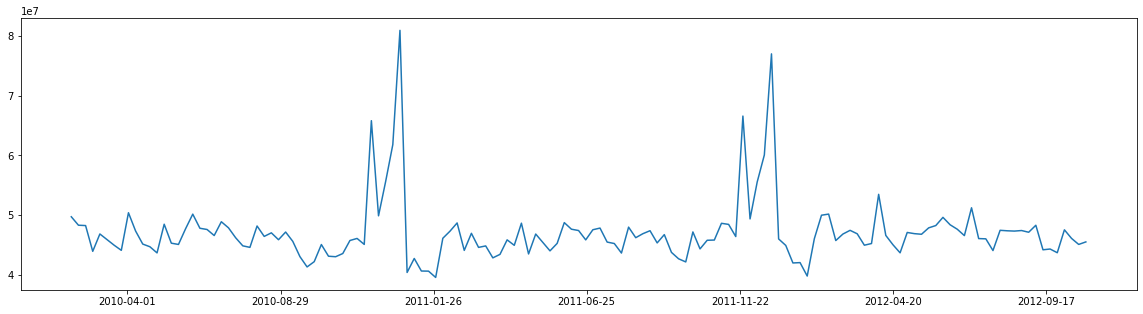

In [6]:
# Average weekly sales for the stores/departments during a week
df_average_sales_weekly = merged_df.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()

df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)

#print(df_average_sales[:10])

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

### Taking into consideration seasonality by adding month variable

In [7]:
merged_df["month"] = merged_df['Date'].dt.month
merged_df = merged_df.drop(["Date"], axis=1)
merged_df = pd.get_dummies(merged_df, columns=["month"])#, prefix='month')
merged_df = pd.get_dummies(merged_df, columns=["Type"])


### Correlation plots

<AxesSubplot:>

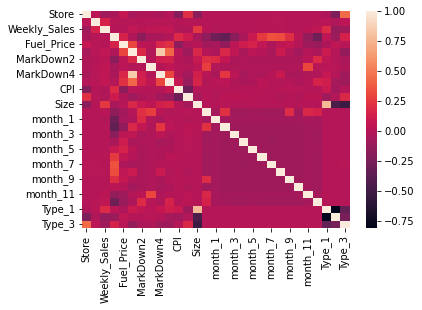

In [8]:
# Correlation between all features
sns.heatmap(merged_df.corr())


<AxesSubplot:>

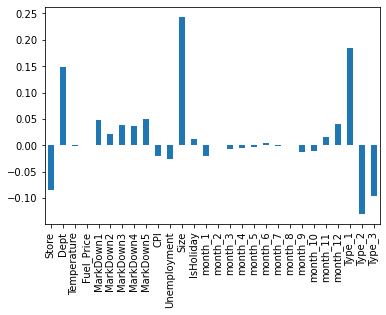

In [9]:
# Correlation between Weekly Sales and all other features
merged_df_corr = merged_df[merged_df.columns[:]].corr()['Weekly_Sales'][:]
merged_df_corr = merged_df_corr.drop("Weekly_Sales")
# Plot the correlation
merged_df_corr.plot.bar()

### Drop low correlation variables

Dropped features due to low correlation: ['Temperature', 'Fuel_Price', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8']


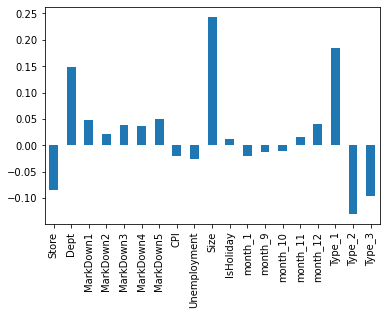

In [10]:
# Set a threshold for correlation
threshold = 0.01

# Filter out the variables with correlation below the threshold
low_corr_features = merged_df_corr[abs(merged_df_corr) < threshold].index
filtered_df = merged_df.drop(columns=low_corr_features)

# Plot the correlation of the remaining features
filtered_df_corr = filtered_df[filtered_df.columns[:]].corr()['Weekly_Sales'][:]
filtered_df_corr = filtered_df_corr.drop("Weekly_Sales")
filtered_df_corr.plot.bar()

# Print the dropped features
print(f"Dropped features due to low correlation: {list(low_corr_features)}")

## Train & Test Data
### Methods:
- Linear regression
- random forest
- ExtraTree


In [11]:
# DF x & y

train_X = filtered_df.drop(["Weekly_Sales"], axis=1)
train_y = filtered_df["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=False, stratify=None)

### Linear regression

In [12]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# Print out the MAE, MSE & RMSE
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 11807.42973696166
Mean Squared Error: 329610100.4691928
Root Mean Squared Error: 18155.16732143201
R2 Score: 0.04863636643366753


### Random Forest

In [13]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf.predict(X_test)

# Print out the MAE, MSE & RMSE for the Random Forest model
print('Random Forest Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Random Forest Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Random Forest Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('Random Forest R2 Score:', metrics.r2_score(y_test, y_pred_rf))

Random Forest Mean Absolute Error: 4426.343323809806
Random Forest Mean Squared Error: 88017046.0309305
Random Forest Root Mean Squared Error: 9381.74003215451
Random Forest R2 Score: 0.7459537295472303


### Gradient Boosting Regressor

In [14]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
gbr.fit(X_train, y_train)

# Predict on the test data
y_pred_gbr = gbr.predict(X_test)

# Print out the MAE, MSE & RMSE for the Gradient Boosting model
print('Gradient Boosting Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_gbr))
print('Gradient Boosting Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_gbr))
print('Gradient Boosting Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbr)))
print('Gradient Boosting R2 Score:', metrics.r2_score(y_test, y_pred_gbr))

Gradient Boosting Mean Absolute Error: 6607.62613970374
Gradient Boosting Mean Squared Error: 105991648.30010495
Gradient Boosting Root Mean Squared Error: 10295.224538595792
Gradient Boosting R2 Score: 0.6940730896567371


### Extra Trees Regressor

In [15]:
# Initialize the Extra Trees Regressor
#etr = ExtraTreesRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42)
etr = ExtraTreesRegressor(
    n_estimators=100,  # More trees may improve performance
    max_depth=15,  # A higher max_depth may improve accuracy but increases computation
    min_samples_split=5,  # A lower value can allow more detailed splits
    random_state=42,
    n_jobs=-1  # Parallelize the training (use all available CPUs)
)
# Fit the model on the entire training data
etr.fit(X_train, y_train)

# Predict on the test data
y_pred_etr = etr.predict(X_test)

# Print out the MAE, MSE & RMSE for the Extra Trees model on the test data
print('Extra Trees Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_etr))
print('Extra Trees Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_etr))
print('Extra Trees Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_etr)))
print('Extra Trees R2 Score:', metrics.r2_score(y_test, y_pred_etr))

Extra Trees Mean Absolute Error: 3973.1607993023626
Extra Trees Mean Squared Error: 51276224.992097974
Extra Trees Root Mean Squared Error: 7160.7419302819435
Extra Trees R2 Score: 0.8519998760517153


### Hyperparameter tunign using gridsearch

In [16]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(etr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the model using the best parameters
best_etr = grid_search.best_estimator_
y_pred_etr = best_etr.predict(X_test)

# Print out the evaluation metrics
print('Extra Trees Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_etr))
print('Extra Trees Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_etr))
print('Extra Trees Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_etr)))
print('Extra Trees R2 Score:', metrics.r2_score(y_test, y_pred_etr))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
Extra Trees Mean Absolute Error: 3818.848886788938
Extra Trees Mean Squared Error: 50594756.60635504
Extra Trees Root Mean Squared Error: 7112.999128803197
Extra Trees R2 Score: 0.8539668189296735


### Stackeing regressor

In [22]:
# Define the base models with reduced complexity and more diversity
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)),
    ('xgb', XGBRegressor(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))
]

# Define the meta-model
meta_model = ExtraTreesRegressor(n_estimators=50, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)

# Create the stacking regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

# Train the stacking regressor
stacking_regressor.fit(X_train, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test)

# Evaluate the model
print('R2 Score:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Score: 0.7746530622041949
Mean Absolute Error: 4811.685779804028
Mean Squared Error: 78073855.44984825
Root Mean Squared Error: 8835.941118514103


### CatBoost Regressor

In [23]:
from catboost import CatBoostRegressor
# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, random_seed=42, verbose=100)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
print('R2 Score:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0:	learn: 22467.2931962	total: 280ms	remaining: 4m 39s
100:	learn: 8240.2108846	total: 12s	remaining: 1m 46s
200:	learn: 6630.0053147	total: 23.8s	remaining: 1m 34s
300:	learn: 5883.0974855	total: 35.1s	remaining: 1m 21s
400:	learn: 5448.5307326	total: 46.5s	remaining: 1m 9s
500:	learn: 5157.0574225	total: 58.4s	remaining: 58.2s
600:	learn: 4936.0341349	total: 1m 10s	remaining: 46.9s
700:	learn: 4755.2369791	total: 1m 23s	remaining: 35.7s
800:	learn: 4606.2832443	total: 1m 38s	remaining: 24.4s
900:	learn: 4481.7488473	total: 1m 53s	remaining: 12.4s
999:	learn: 4376.1080928	total: 2m 5s	remaining: 0us
R2 Score: 0.780873484191565
Mean Absolute Error: 4780.014914011914
Mean Squared Error: 75918723.75900163
Root Mean Squared Error: 8713.135128012284
